### Library load

In [30]:
import spacy
import torch
from torchtext.datasets import Multi30k
import torch.nn as nn
from torchtext.data import Field, BucketIterator
import math
from torch.autograd import Variable


### Data preprocessing
- **Spacy**<br>
    Tokenization, Part-of-speech Tagging, etc. <br>
    Here, Spacy was used for tokenizer<br><br>
   
- **Field** [Link](https://torchtext.readthedocs.io/en/latest/data.html#field)<br>
    Defines a datatype together with instructions for converting to Tensor. <br><br>
- **BucketIterator** [Link](https://torchtext.readthedocs.io/en/latest/data.html#bucketiterator)<br>
    Defines an iterator that batches examples of similar lengths together. <br>
    Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. <br>
    See pool for the bucketing procedure used.



In [2]:
spacy_en = spacy.load('en_core_web_sm') # Tokenizer (EN)
spacy_de = spacy.load('de_core_news_sm') # Tokenizer (DE)

In [3]:
def tokenize_de(text):
    """ 
    Return a list of tokenized sentences of German
    """
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """ 
    Return a list of tokenized sentences of English
    """    
    return [token.text for token in spacy_en.tokenizer(text)]

In [4]:
## Tokenizer example
sentence = "I am a graduate student."
tokenized = spacy_en.tokenizer(sentence)
print(f"Before tokenized, {sentence}\n")
print("After tokenized")
for i, token in enumerate(tokenized):
    print(f"Index {i}: {token.text}")

Before tokenized, I am a graduate student.

After tokenized
Index 0: I
Index 1: am
Index 2: a
Index 3: graduate
Index 4: student
Index 5: .


Input: German --> Output: English<br>Thus, SRC: German and TGT: English

In [5]:
SRC = Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
TRG = Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

## Multi30k dataset load (데이터 로드 코드 수정부)
- 데이터는 https://github.com/multi30k/dataset 여기서 받았습니다
- 데이터 파일은 ./multi30k 안에 있습니다

In [6]:
train_dataset = Multi30k(path='./multi30k/',exts=('train.de','train.en'), fields=(SRC,TRG))
valid_dataset = Multi30k(path='./multi30k/',exts=('val.de','val.en'), fields=(SRC,TRG))
test_dataset = Multi30k(path='./multi30k/',exts=('test_2016_flickr.de','test_2016_flickr.en'), fields=(SRC,TRG))

In [7]:
train_dataset.examples[30].trg

['a',
 'man',
 'standing',
 'at',
 'a',
 'urinal',
 'with',
 'a',
 'coffee',
 'cup',
 '.']

In [8]:
print(f"학습 데이터셋(training dataset) 크기: {len(train_dataset.examples)}개")
print(f"평가 데이터셋(validation dataset) 크기: {len(valid_dataset.examples)}개")
print(f"테스트 데이터셋(testing dataset) 크기: {len(test_dataset.examples)}개")

학습 데이터셋(training dataset) 크기: 29000개
평가 데이터셋(validation dataset) 크기: 1014개
테스트 데이터셋(testing dataset) 크기: 1000개


#### Example of train/test dataset

In [9]:
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['ein', 'mann', ',', 'der', 'mit', 'einer', 'tasse', 'kaffee', 'an', 'einem', 'urinal', 'steht', '.']
['a', 'man', 'standing', 'at', 'a', 'urinal', 'with', 'a', 'coffee', 'cup', '.']


### Build vocab from train dataset (If a word appear more than once, the word added into vocab)

In [10]:
SRC.build_vocab(train_dataset, min_freq=2)
TRG.build_vocab(train_dataset, min_freq=2)

print(f"len(SRC): {len(SRC.vocab)}")
print(f"len(TRG): {len(TRG.vocab)}")

len(SRC): 7853
len(TRG): 5893


In [11]:
print(TRG.vocab.stoi["abcabc"]) # 없는 단어: 0
print(TRG.vocab.stoi[TRG.pad_token]) # 패딩(padding): 1
print(TRG.vocab.stoi["<sos>"]) # <sos>: 2
print(TRG.vocab.stoi["<eos>"]) # <eos>: 3
print(TRG.vocab.stoi["hello"])
print(TRG.vocab.stoi["world"])

0
1
2
3
4112
1752


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_dataset, valid_dataset, test_dataset),
                                                                        batch_size=BATCH_SIZE,
                                                                        device=device)

In [13]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 24])
인덱스 0: 2
인덱스 1: 18
인덱스 2: 30
인덱스 3: 7
인덱스 4: 71
인덱스 5: 627
인덱스 6: 9
인덱스 7: 185
인덱스 8: 23
인덱스 9: 11
인덱스 10: 6
인덱스 11: 13
인덱스 12: 9
인덱스 13: 15
인덱스 14: 8
인덱스 15: 789
인덱스 16: 7279
인덱스 17: 7
인덱스 18: 15
인덱스 19: 81
인덱스 20: 37
인덱스 21: 4
인덱스 22: 3
인덱스 23: 1


In [14]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

In [15]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

# 내용 설명 시작 (이병조)

## Encoder (Single encoder layer)

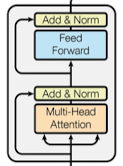

- Multi-Head Attention -> residual connection & layer norm
<br>

### Hyperparameters
- **hidden_dim**<br>
    하나의 token에 대한 embedding dimension<br>

- **n_heads**<br>
    Multi-Head Attention을 위한 head의 개수 (논문 내 parameter: $h$)<br>
    
- **pf_dim** <br>
    Positional-wise Feed-Forward 내 inner-layer 차원 (논문 내 parameter: $d_{ff}$)<br>
    
- **dropout_ratio** <br>
    Dropout 비율. 각 sub-layer의 output에 모두 dropout이 적용되어 있음.

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask) ### Q, K, V, Mask

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

### Multiple stacked encoders
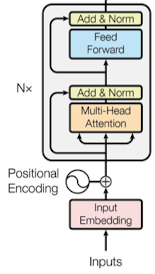

- Input Embedding + Positional encoding (SRC: German)
- Multiple stacked encoders (Dim. of input == Dim. of output)


### Hyperparameters

- **input_dim**<br>
    Vocab size
- **hidden_dim**<br>
    하나의 token에 대한 embedding dimension<br>
- **n_layers** <br>
    모델에서 사용 할 인코더 수<br>
- **n_heads**<br>
    Multi-Head Attention을 위한 head의 개수 (논문 내 parameter: $h$)<br>
- **pf_dim** <br>
    Positional-wise Feed-Forward 내 inner-layer 차원 (논문 내 parameter: $d_{ff}$)<br>
- **dropout_ratio** <br>
    Dropout 비율. 각 sub-layer의 output에 모두 dropout이 적용되어 있음.<br>
    
### Positional Encoder
- 현재 2가지 positional encoder가 있음
1. 논문에서 제시된 사인/코사인 함수를 이용한 경우
2. Position자체도 embedding layer를 이용하는 경우 (token embedding 하고 같은 방식이나 embedding layer의 입력이 0, 1, 2, ... 와 같이 정수의 증가로 구성되어 있음)
- 1번을 사용하기 위해서는 Encoder instance 생성 시 originalPE = True 선언
- 2번을 사용하기 위해서는 originalPE = False 선언 (Default)

In [117]:
import matplotlib.pyplot as plt

In [ ]:
torch.Size([128, 27, 256])
torch.Size([1, 100, 27])

In [199]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, \
                 max_length=100, originalPE=False, batch_size = 128):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) \
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

        
        ### For original posEncoder
        self.originalPE = originalPE
        self.encoding = torch.zeros(max_length, hidden_dim)
        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2) * -(math.log(10000.0) / hidden_dim))
        self.encoding[:,0::2] = torch.sin(position * div_term)
        self.encoding[:,1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).to(device)
        # plt.pcolor(self.encoding)
        ## self.encoding: [1, max_len, hidden_dim]
        
        
    def posEncoder(self, x):
        # print(x.shape)
        # print(Variable(self.encoding[:, :x.size(1), :], requires_grad=False).shape)        
        return x + Variable(self.encoding[:, :x.size(1), :], requires_grad=False) ## Original posENC is not trainable
    
    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        if self.originalPE:
            src = self.dropout(self.posEncoder(self.tok_embedding(src) * self.scale))
        else:
            # pos: [batch_size, src_len]
            pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
            ''' 
            When src_len = 5 & batch_size = 3,
            pos = [
            [0, 1, 2, 3, 4],
            [0, 1, 2, 3, 4],
            [0, 1, 2, 3, 4]
            ]
            '''
            # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용            
            src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

## Decoder (Single decoder layer)

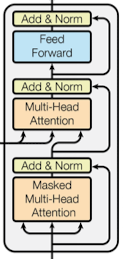

- Masked Multi-Head Attention (Self) 
- Multi-Head Attention (Q, K from Encoder, V from Decoder)
- Residual connection & layer norm
<br>

### Hyperparameters
- **hidden_dim**<br>
    하나의 token에 대한 embedding dimension<br>

- **n_heads**<br>
    Multi-Head Attention을 위한 head의 개수 (논문 내 parameter: $h$)<br>
    
- **pf_dim** <br>
    Positional-wise Feed-Forward 내 inner-layer 차원 (논문 내 parameter: $d_{ff}$)<br>
    
- **dropout_ratio** <br>
    Dropout 비율. 각 sub-layer의 output에 모두 dropout이 적용되어 있음.

In [200]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

## Decoder

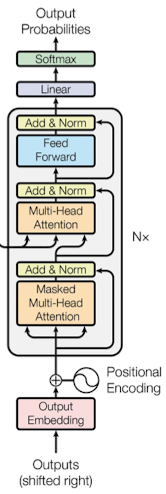
- Input Embedding + Positional encoding (TRG: English)
- Multiple stacked decoders (Dim. of input == Dim. of output)
- Linear
<br>

- **output_dim**<br>
    Vocab size (English)
- **hidden_dim**<br>
    하나의 token에 대한 embedding dimension<br>
- **n_layers** <br>
    모델에서 사용 할 인코더 수<br>
- **n_heads**<br>
    Multi-Head Attention을 위한 head의 개수 (논문 내 parameter: $h$)<br>
- **pf_dim** <br>
    Positional-wise Feed-Forward 내 inner-layer 차원 (논문 내 parameter: $d_{ff}$)<br>
- **dropout_ratio** <br>
    Dropout 비율. 각 sub-layer의 output에 모두 dropout이 적용되어 있음.<br>
    
### Positional Encoder
- 현재 2가지 positional encoder가 있음
1. 논문에서 제시된 사인/코사인 함수를 이용한 경우
2. Position자체도 embedding layer를 이용하는 경우 (token embedding 하고 같은 방식이나 embedding layer의 입력이 0, 1, 2, ... 와 같이 정수의 증가로 구성되어 있음)
- 1번을 사용하기 위해서는 Encoder instance 생성 시 originalPE = True 선언
- 2번을 사용하기 위해서는 originalPE = False 선언 (Default)


In [201]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, \
                 max_length=100, originalPE=False, batch_size=128):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

        ### For original posEncoder
        self.originalPE = originalPE
        self.encoding = torch.zeros(max_length, hidden_dim)
        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2) * -(math.log(10000.0) / hidden_dim))
        self.encoding[:,0::2] = torch.sin(position * div_term)
        self.encoding[:,1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).to(device)
        # plt.pcolor(self.encoding)
        ## self.encoding: [1, max_len, hidden_dim]
        
        
    def posEncoder(self, x):
        # print(x)
        # print(Variable(self.encoding[:, :, :x.size(1)], requires_grad=False).shape)
        return x + Variable(self.encoding[:, :x.size(1), :], requires_grad=False) ## Original posENC is not trainable
        
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        if self.originalPE:
            trg = self.dropout(self.posEncoder(self.tok_embedding(trg) * self.scale))
        else:        
            pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

            # pos: [batch_size, trg_len]

            trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

            # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

## Transformer

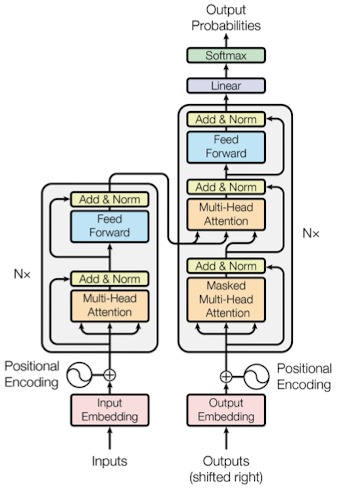
<br>

### Masking
- SRC의 경우에는 \<PAD> 토큰에 대해서 masking 작업
- TGT의 경우에는 다음의 입력 값 (subsequent position)과의 attention을 구하지 못하게 하기 위해 마스킹 작업 수행


In [202]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

In [203]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [204]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device, originalPE=True)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device, originalPE=True)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [220]:
enc.encoding.cpu().numpy()

array([[[ 0.0000000e+00,  1.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  5.4030234e-01,  8.0196178e-01, ...,
          1.0000000e+00,  1.0746076e-04,  1.0000000e+00],
        [ 9.0929741e-01, -4.1614684e-01,  9.5814437e-01, ...,
          1.0000000e+00,  2.1492151e-04,  1.0000000e+00],
        ...,
        [ 3.7960774e-01, -9.2514753e-01,  7.4510968e-01, ...,
          9.9993730e-01,  1.0423505e-02,  9.9994570e-01],
        [-5.7338190e-01, -8.1928825e-01, -8.9752287e-02, ...,
          9.9993598e-01,  1.0530960e-02,  9.9994457e-01],
        [-9.9920684e-01,  3.9820880e-02, -8.5234123e-01, ...,
          9.9993467e-01,  1.0638415e-02,  9.9994344e-01]]], dtype=float32)

## 논문에 나와있는 Positional encoder visualization

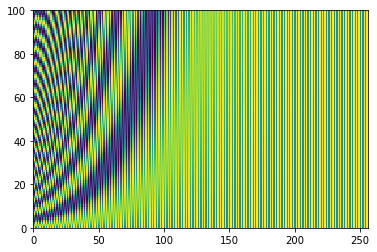

In [225]:
plt.pcolor(enc.encoding.cpu().squeeze())

# 내용 설명 끝

In [205]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


In [206]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
 

In [207]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [208]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1])

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1)

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [209]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [210]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [211]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 6s
	Train Loss: 4.508 | Train PPL: 90.776
	Validation Loss: 3.385 | Validation PPL: 29.523
Epoch: 02 | Time: 0m 6s
	Train Loss: 3.205 | Train PPL: 24.660
	Validation Loss: 2.616 | Validation PPL: 13.684
Epoch: 03 | Time: 0m 6s
	Train Loss: 2.519 | Train PPL: 12.413
	Validation Loss: 2.114 | Validation PPL: 8.284
Epoch: 04 | Time: 0m 6s
	Train Loss: 2.074 | Train PPL: 7.959
	Validation Loss: 1.853 | Validation PPL: 6.377
Epoch: 05 | Time: 0m 6s
	Train Loss: 1.786 | Train PPL: 5.964
	Validation Loss: 1.723 | Validation PPL: 5.601
Epoch: 06 | Time: 0m 6s
	Train Loss: 1.576 | Train PPL: 4.837
	Validation Loss: 1.640 | Validation PPL: 5.153
Epoch: 07 | Time: 0m 6s
	Train Loss: 1.414 | Train PPL: 4.112
	Validation Loss: 1.591 | Validation PPL: 4.909
Epoch: 08 | Time: 0m 6s
	Train Loss: 1.285 | Train PPL: 3.615
	Validation Loss: 1.581 | Validation PPL: 4.862
Epoch: 09 | Time: 0m 6s
	Train Loss: 1.181 | Train PPL: 3.259
	Validation Loss: 1.557 | Validation PPL: 4.745
Epoch